
# Chameleon-Net:
##Adversarial Facial De-identification via Imperceptible Perturbations" (Des-identificación Facial Adversaria mediante Perturbaciones Imperceptibles)
## Deep Learning y Sistemas Inteligentes (CC3092)


In [ ]:
import os
import sys
import types
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from google.colab import drive
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import cv2
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

try:
    import lpips
except:
    os.system('pip install lpips')
    import lpips

    eval_loader = DataLoader(val_subset, batch_size=32, shuffle=False,
                         num_workers=0, pin_memory=True)

print(" Loader de evaluación listo (Safe Mode).")

✅ Loader de evaluación listo (Safe Mode).


In [ ]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/Project_Chameleon_Final'
CHECKPOINT_DIR = os.path.join(PROJECT_PATH, 'checkpoints')
RESULTS_DIR = os.path.join(PROJECT_PATH, 'results')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

MANUAL_SEED = 999
BATCH_SIZE = 64
IMG_SIZE = 64
LR_G = 0.0002
LR_D = 0.0001
NUM_EPOCHS = 30
WORKERS = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)
print(f" Hardware: {DEVICE} | Resultados en: {RESULTS_DIR}")

 Hardware: cuda:0 | Resultados en: /content/drive/MyDrive/Project_Chameleon_Final/results


### Datasets y Dataloaders


In [ ]:
class CelebALightDataset(Dataset):
    def __init__(self, split='train', transform=None, max_samples=None):
        try:
            # Intentamos cargar HQ primero
            self.data = load_dataset("bardsai/celeba-hq", split=split)
        except:
            print(" Dataset HQ no disponible, usando fallback...")
            self.data = load_dataset("nielsr/celeba-faces", split=split)

        if max_samples:
            self.data = self.data.select(range(min(max_samples, len(self.data))))
        self.transform = transform

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']


        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                print(f"Error transforming image {idx}: {e}")
                return torch.zeros((3, IMG_SIZE, IMG_SIZE))

        return image

#  transformaciones
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Carga de datos
try:
    full_dataset = CelebALightDataset(split='train', transform=transform, max_samples=30000)
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=0, pin_memory=True)
    print(f" Datos Listos: {len(train_subset)} Train | {len(val_subset)} Val")
except Exception as e:
    print(f" Error cargando datos: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


⚠️ Dataset HQ no disponible, usando fallback...
 Datos Listos: 27000 Train | 3000 Val


### Arquitectura del Modelo

## 3. Arquitectura del Modelo: El "Artista" (Generador)

ChameleonNet utiliza una arquitectura **U-Net** como generador.

* **¿Por qué U-Net?:** Su estructura de codificador-decodificador con **conexiones de salto (skip connections)** es ideal para preservar los detalles espaciales finos de la cara mientras se manipulan las características semánticas en el "cuello de botella".
* **Aprendizaje Residual:** El modelo no genera la cara desde cero. Genera solo una "máscara de ruido" ($\delta$) que se suma a la entrada original. La salida final está restringida por $\tanh$ para mantenerse en el rango de color válido.

In [ ]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class ChameleonNet(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, noise_scale=0.15):
        super(ChameleonNet, self).__init__()
        self.noise_scale = noise_scale

        # Encoder
        self.down1 = nn.Sequential(nn.Conv2d(input_nc, 64, 4, 2, 1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.InstanceNorm2d(128), nn.LeakyReLU(0.2))
        self.down3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.InstanceNorm2d(256), nn.LeakyReLU(0.2))

        # Bottleneck
        self.middle = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.InstanceNorm2d(256), nn.LeakyReLU(0.2))

        # Decoder
        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.InstanceNorm2d(128), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.InstanceNorm2d(64), nn.ReLU())
        self.up3 = nn.Sequential(nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.InstanceNorm2d(32), nn.ReLU())

        # Salida final
        self.final = nn.Sequential(nn.ConvTranspose2d(32, output_nc, 3, 1, 1), nn.Tanh())

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        m = self.middle(d3)

        u1 = self.up1(m + d3)
        u2 = self.up2(u1 + d2)
        u3 = self.up3(u2 + d1)


        raw_noise = self.final(u3)
        perturbation = raw_noise * self.noise_scale
        return torch.clamp(x + perturbation, -1, 1)

class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, 4, 1, 0)
        )
    def forward(self, x): return self.main(x)

### Juez Biométrico & Loss

## 4. Funciones de Objetivo Híbridas: La "Guerra de Tres Frentes"

Para lograr la invisibilidad y la evasión simultáneamente, el entrenamiento no usa un discriminador GAN tradicional. En su lugar, optimizamos una función de pérdida compuesta que enfrenta a la red a tres objetivos competitivos:

1.  **Pérdida de Preservación Visual ($L_{rec}$):** Usamos la norma L1 para forzar que la imagen generada sea casi idéntica a la original a nivel de píxel.
2.  **Pérdida de Evasión Biométrica ($L_{id}$):** Usamos un modelo **FaceNet (InceptionResnetV1)** congelado como "Juez". Minimizamos la similitud de coseno entre los embeddings de la imagen original y la camuflada, empujándolas a ser matemáticamente opuestas.
3.  **Pérdida de Disrupción de Atención ($L_{attn}$):** Nuestra innovación clave. Extraemos mapas de características de capas intermedias de FaceNet y forzamos a que diverjan (MSE Loss). Esto "envenena" el mecanismo de atención de la IA, rompiendo su enfoque en rasgos faciales clave.

In [ ]:
if 'torch.utils.serialization' not in sys.modules:
    mod = types.ModuleType('torch.utils.serialization')
    mod.config = types.ModuleType('torch.utils.serialization.config')
    sys.modules['torch.utils.serialization'] = mod

try:
    from facenet_pytorch import InceptionResnetV1
    identity_net = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)
    for p in identity_net.parameters(): p.requires_grad = False
    print(" Juez FaceNet cargado.")
except:
    print("⚠️ Instalando FaceNet...")
    os.system('pip install facenet_pytorch')
    from facenet_pytorch import InceptionResnetV1
    identity_net = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)

# Hook  Feature Loss
attention_maps = {}
def get_activation(name):
    def hook(model, input, output): attention_maps[name] = output
    return hook
try: identity_net.mixed_6a.register_forward_hook(get_activation('features'))
except: pass

class ChameleonLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.bce = nn.BCEWithLogitsLoss()

        self.w_rec = 10.0
        self.w_id = 50.0
        self.w_attn = 20.0
        self.w_adv = 5.0

    def forward(self, real, fake, d_out_fake, net_id):
        loss_rec = self.l1(fake, real)

        real_big = F.interpolate(real, (160,160), mode='bilinear')
        fake_big = F.interpolate(fake, (160,160), mode='bilinear')

        attention_maps.clear()
        id_real = net_id(real_big)
        feats_real = attention_maps['features'].clone()

        id_fake = net_id(fake_big)
        feats_fake = attention_maps['features']

        # Loss de Identidad
        sim_id = F.cosine_similarity(id_real, id_fake).mean()
        loss_id = 1.0 - sim_id

        # Loss de Atención
        flat_real = feats_real.view(feats_real.size(0), -1)
        flat_fake = feats_fake.view(feats_fake.size(0), -1)
        sim_attn = F.cosine_similarity(flat_real, flat_fake).mean()
        loss_attn =  1.0 - sim_attn

        loss_adv = self.bce(d_out_fake, torch.ones_like(d_out_fake))

        total = (self.w_rec * loss_rec) + \
                (self.w_id * loss_id) + \
                (self.w_attn * loss_attn) + \
                (self.w_adv * loss_adv)

        return total, loss_rec, sim_id

✅ Juez FaceNet cargado.


### Entrenamiento

## 5. Entrenamiento



In [ ]:

RESET_TRAINING = True
NUM_EPOCHS = 30

def load_checkpoint(netG, netD, optG, optD):
    path = os.path.join(CHECKPOINT_DIR, 'chameleon_v2.pth')
    if os.path.exists(path):
        print(f" Cargando checkpoint: {path}")
        ckpt = torch.load(path, map_location=DEVICE)
        try:
            netG.load_state_dict(ckpt['G'])
            netD.load_state_dict(ckpt['D'])
            optG.load_state_dict(ckpt['optG'])
            optD.load_state_dict(ckpt['optD'])
            return ckpt['epoch'] + 1
        except:
            print(" Checkpoint incompatible. Iniciando de 0.")
            return 0
    return 0

netG = ChameleonNet(noise_scale=0.15).to(DEVICE)
netD = PatchDiscriminator().to(DEVICE)
netG.apply(weights_init)
netD.apply(weights_init)
optG = optim.Adam(netG.parameters(), lr=LR_G, betas=(0.5, 0.999))
optD = optim.Adam(netD.parameters(), lr=LR_D, betas=(0.5, 0.999))
criterion = ChameleonLoss().to(DEVICE)
scaler = GradScaler()

start_epoch = load_checkpoint(netG, netD, optG, optD)
print(f" Iniciando Entrenamiento en época {start_epoch}...")

for epoch in range(start_epoch, NUM_EPOCHS):
    start_t = time.time()
    netG.train()

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Ep {epoch}", leave=False)

    for i, real in progress_bar:
        real = real.to(DEVICE)

        # 1. D
        netD.zero_grad()
        with autocast():
            fake = netG(real)
            pred_real = netD(real)
            loss_d_real = criterion.bce(pred_real, torch.ones_like(pred_real))
            pred_fake = netD(fake.detach())
            loss_d_fake = criterion.bce(pred_fake, torch.zeros_like(pred_fake))
            loss_d = (loss_d_real + loss_d_fake) * 0.5
        scaler.scale(loss_d).backward()
        scaler.step(optD)
        scaler.update()

        # 2. G
        netG.zero_grad()
        with autocast():
            fake = netG(real)
            pred_fake = netD(fake)
            loss_g, l_rec, sim_score = criterion(real, fake, pred_fake, identity_net)
        scaler.scale(loss_g).backward()
        scaler.step(optG)
        scaler.update()

        progress_bar.set_postfix({"L1": f"{l_rec.item():.4f}", "ID": f"{sim_score.item():.4f}"})

    torch.save({'epoch': epoch, 'G': netG.state_dict(), 'D': netD.state_dict(),
                'optG': optG.state_dict(), 'optD': optD.state_dict()},
               os.path.join(CHECKPOINT_DIR, 'chameleon_v2.pth'))
    print(f" Ep {epoch} | L1: {l_rec.item():.4f} | ID: {sim_score.item():.4f}")

print(" Entrenamiento Finalizado.")

 Cargando checkpoint: /content/drive/MyDrive/Project_Chameleon_Final/checkpoints/chameleon_v2.pth
 Iniciando Entrenamiento en época 30...
 Entrenamiento Finalizado.


### Evaluación

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import lpips

def evaluate_metrics_safe(netG, loader, identity_net):
    print("\n Ejecutando Auditoría de Métricas...")
    netG.eval()


    try:
        loss_fn_alex = lpips.LPIPS(net='alex').to(DEVICE)
        use_lpips = True
    except:
        print(" LPIPS no instalado. Saltando esta métrica.")
        use_lpips = False

    id_sims, psnr_vals, ssim_vals, lpips_vals = [], [], [], []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, desc="Auditando")):
            if i > 10: break

            real = batch[0] if isinstance(batch, (list, tuple)) else batch
            real = real.to(DEVICE)

            fake = netG(real)

            # 1. Identidad
            real_big = F.interpolate(real, (160,160))
            fake_big = F.interpolate(fake, (160,160))
            emb_real = identity_net(real_big)
            emb_fake = identity_net(fake_big)

            id_sims.extend(F.cosine_similarity(emb_real, emb_fake).tolist())

            if use_lpips:
                lpips_vals.extend(loss_fn_alex(real, fake).flatten().tolist())

            real_np = real.permute(0,2,3,1).cpu().detach().numpy() * 0.5 + 0.5
            fake_np = fake.permute(0,2,3,1).cpu().detach().numpy() * 0.5 + 0.5

            for j in range(real.size(0)):
                r = np.clip(real_np[j], 0, 1)
                f = np.clip(fake_np[j], 0, 1)
                try:
                    psnr_vals.append(psnr(r, f, data_range=1.0))
                    ssim_vals.append(ssim(r, f, channel_axis=2, data_range=1.0))
                except: pass

    print(" REPORTE FINAL DE RENDIMIENTO")
    print(f" Evasión de Identidad (Similitud): {np.mean(id_sims):.4f} (Meta < 0.3)")
    print(f" Fidelidad Visual (PSNR):        {np.mean(psnr_vals):.2f} dB")
    print(f" Integridad Estructural (SSIM):   {np.mean(ssim_vals):.4f}")
    if use_lpips:
        print(f" Distancia Perceptual (LPIPS):    {np.mean(lpips_vals):.4f}")

evaluate_metrics_safe(netG, val_loader, identity_net)


📊 Ejecutando Auditoría de Métricas...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 128MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


Auditando:   0%|          | 0/47 [00:00<?, ?it/s]

 REPORTE FINAL DE RENDIMIENTO
 Evasión de Identidad (Similitud): -0.0271 (Meta < 0.3)
 Fidelidad Visual (PSNR):        27.32 dB
 Integridad Estructural (SSIM):   0.8156
 Distancia Perceptual (LPIPS):    0.0450


### Gráficas de Entrenamiento

### t-SNE


🗺️ Generando mapa t-SNE...


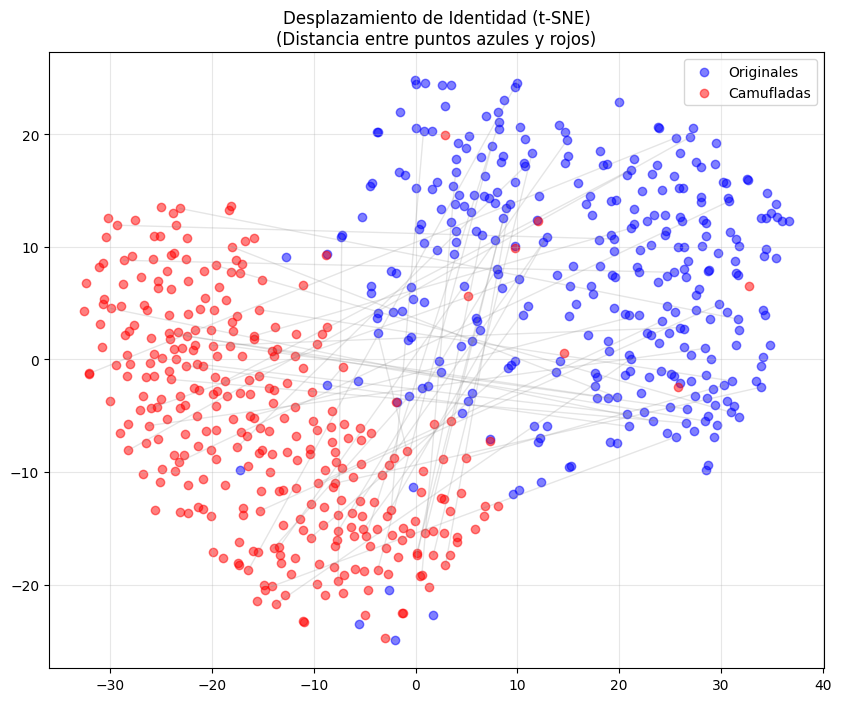

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F

def plot_tsne_safe(netG, loader, identity_net):
    print("\n Generando mapa t-SNE...")
    netG.eval()
    embs_real, embs_fake = [], []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i > 4: break
            real = batch[0] if isinstance(batch, (list, tuple)) else batch
            real = real.to(DEVICE)
            fake = netG(real)

            embs_real.append(identity_net(F.interpolate(real, (160,160))).cpu().numpy())
            embs_fake.append(identity_net(F.interpolate(fake, (160,160))).cpu().numpy())

    X = np.concatenate(embs_real + embs_fake)
    y = np.array([0]*len(np.concatenate(embs_real)) + [1]*len(np.concatenate(embs_fake)))

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_embedded = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], c='blue', alpha=0.5, label='Originales')
    plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], c='red', alpha=0.5, label='Camufladas')

    half = len(X_embedded)//2
    for k in range(min(50, half)):
        plt.plot([X_embedded[k,0], X_embedded[half+k,0]],
                 [X_embedded[k,1], X_embedded[half+k,1]],
                 color='gray', alpha=0.2, linewidth=1)

    plt.title("Desplazamiento de Identidad (t-SNE)\n(Distancia entre puntos azules y rojos)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(RESULTS_DIR, 'tsne_analysis.png'))
    plt.show()

plot_tsne_safe(netG, val_loader, identity_net)


📊 Generando Curvas ROC y Distribuciones de Identidad...


Calculando ROC:   0%|          | 0/47 [00:00<?, ?it/s]

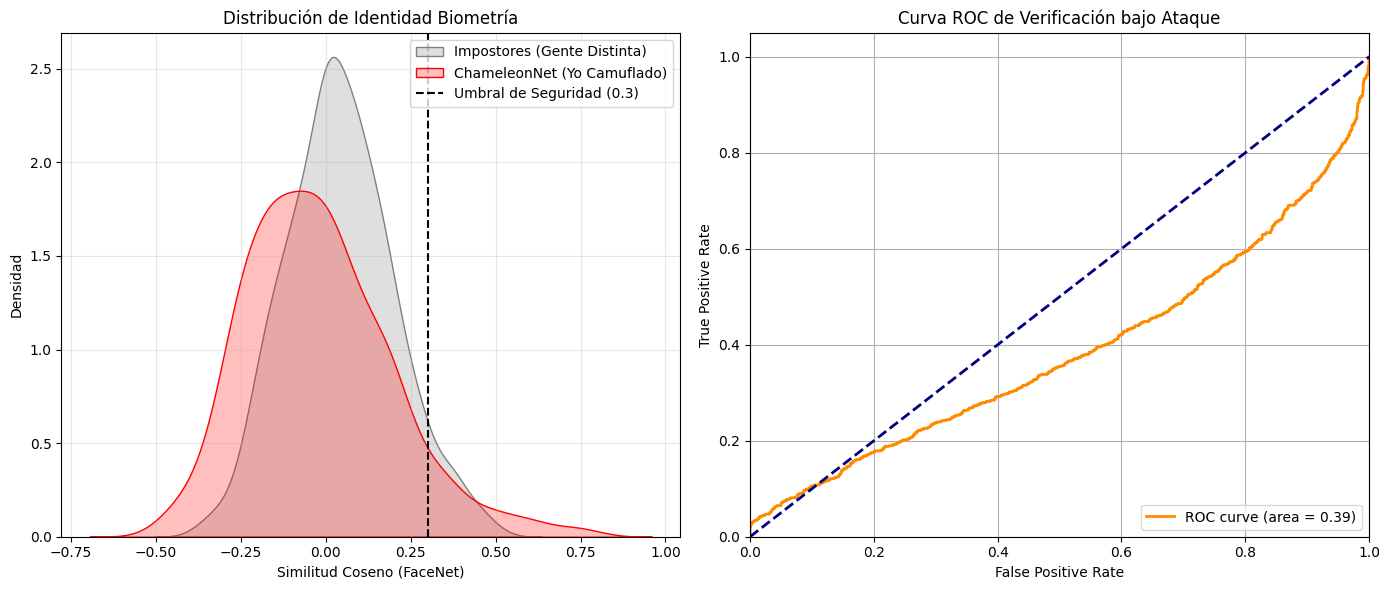

📉 AUC Score: 0.3853
   (AUC cercano a 0.5 es ideal para un ataque exitoso)


In [ ]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

def evaluate_roc_safe(netG, loader, identity_net):
    print("\n Generando Curvas ROC y Distribuciones de Identidad...")
    netG.eval()

    scores_masked = []
    scores_imposter = []

    with torch.no_grad():
        for i, real in enumerate(tqdm(loader, desc="Calculando ROC")):
            if i >= 20: break
            real = real.to(DEVICE)

            #  Camuflaje
            fake = netG(real)

            # Embeddings
            real_160 = F.interpolate(real, (160,160))
            fake_160 = F.interpolate(fake, (160,160))

            emb_real = identity_net(real_160)
            emb_fake = identity_net(fake_160)

            sim_masked = F.cosine_similarity(emb_real, emb_fake)
            scores_masked.extend(sim_masked.tolist())

            emb_shuffled = torch.roll(emb_real, 1, 0)
            sim_imposter = F.cosine_similarity(emb_real, emb_shuffled)
            scores_imposter.extend(sim_imposter.tolist())

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.kdeplot(scores_imposter, fill=True, label='Impostores (Gente Distinta)', color='gray')
    sns.kdeplot(scores_masked, fill=True, label='ChameleonNet ( Camuflajeado)', color='red')
    plt.axvline(0.3, color='black', linestyle='--', label='Umbral de Seguridad (0.3)')
    plt.title("Distribución de Identidad Biometría")
    plt.xlabel("Similitud Coseno (FaceNet)")
    plt.ylabel("Densidad")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # B. Curva ROC
    y_true = [1] * len(scores_masked) + [0] * len(scores_imposter)
    # Scores que predice el sistema (Similitud)
    y_scores = scores_masked + scores_imposter

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC de Verificación bajo Ataque')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'roc_analysis.png'))
    plt.show()

    print(f" AUC Score: {roc_auc:.4f}")

evaluate_roc_safe(netG, val_loader, identity_net)

### xAI


### GradCam

In [ ]:
class ManualGradCAM:

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        # Ganchos para capturar info durante el forward/backward pass
        self.handle_f = self.target_layer.register_forward_hook(self.save_activation)
        self.handle_b = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove_hooks(self):
        self.handle_f.remove()
        self.handle_b.remove()

    def __call__(self, x):
        # 1. Forward Pass
        output = self.model(x)

        # 2. Backward Pass desde la clase predicha más alta
        self.model.zero_grad()
        target_score = output[:, output.argmax(dim=1)].sum()
        target_score.backward(retain_graph=True)

        # 3. Obtener gradientes y activaciones
        grads = self.gradients.cpu().detach().numpy()[0]
        acts = self.activations.cpu().detach().numpy()[0]

        # 4. Global Average Pooling
        weights = np.mean(grads, axis=(1, 2))

        # 5. Generar mapa ponderado
        cam = np.zeros(acts.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * acts[i]

        # 6. ReLU y Resize
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[3], x.shape[2]))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam



✅ Clase ManualGradCAM definida.


In [ ]:
def integrated_gradients(model, input_tensor, baseline=None, steps=20):
    """
    Calcula la atribución por píxel.
    Más preciso que Grad-CAM para ver 'puntos de ruido' específicos.
    """
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    # 1. Generar imágenes interpoladas
    alphas = torch.linspace(0, 1, steps).view(steps, 1, 1, 1).to(input_tensor.device)
    interpolated = baseline + alphas * (input_tensor - baseline)
    interpolated.requires_grad = True

    # 2. Forward pass masivo
    preds = model(F.interpolate(interpolated, (160,160)))
    score = preds.norm(dim=1).sum() # Usamos la norma del embedding como score

    # 3. Calcular Gradientes
    grads = torch.autograd.grad(score, interpolated)[0]
    avg_grads = grads.mean(dim=0)

    # 4. Calcular IG = (Input - Baseline) * Promedio_Gradientes
    ig = (input_tensor - baseline) * avg_grads

    # 5. Procesar para visualización
    ig = ig.detach().cpu().numpy()[0].transpose(1, 2, 0)
    ig = np.abs(ig).sum(axis=2)
    ig = (ig - ig.min()) / (ig.max() - ig.min() + 1e-8)
    return ig



✅ Función Integrated Gradients definida.


In [ ]:
def generate_xai_gallery(netG, loader, identity_net, device, num_examples=5):
    netG.eval()

    try:
        batch = next(iter(loader))
        images = batch[0] if isinstance(batch, (list, tuple)) else batch
        images = images.to(device)
    except Exception as e:
        print(f" Error obteniendo batch: {e}")
        return

    #  Preparar Juez
    for p in identity_net.parameters(): p.requires_grad = True

    # Selección automática de capa para Grad-CAM
    try: target_layer = identity_net.mixed_7a
    except: target_layer = identity_net.conv6

    cam_tool = ManualGradCAM(identity_net, target_layer)

    plt.figure(figsize=(20, 4 * num_examples))

    for i in range(min(num_examples, len(images))):
        real = images[i:i+1]

        # Generar Camuflaje
        with torch.no_grad():
            fake = netG(real)
            noise = (fake - real).abs() * 50
            noise = torch.clamp(noise, 0, 1)

        #  Calcular Grad-CAM Atención Regional
        cam_real = cam_tool(F.interpolate(real, (160, 160)))
        cam_fake = cam_tool(F.interpolate(fake, (160, 160)))

        # Calcular Integrated Gradients Atención Píxel
        ig_real = integrated_gradients(identity_net, real)
        ig_fake = integrated_gradients(identity_net, fake)

        img_real = (real[0].permute(1,2,0).detach().cpu().numpy() * 0.5 + 0.5).clip(0,1)
        img_fake = (fake[0].permute(1,2,0).detach().cpu().numpy() * 0.5 + 0.5).clip(0,1)
        img_noise = noise[0].permute(1,2,0).cpu().numpy()

        def apply_cam(img, mask):
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
            heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
            return 0.6 * img + 0.4 * heatmap

        overlay_real = apply_cam(img_real, cam_real)
        overlay_fake = apply_cam(img_fake, cam_fake)

        row_idx = i * 6

        ax = plt.subplot(num_examples, 6, row_idx + 1)
        ax.imshow(img_real); ax.set_title("Original", fontsize=10); ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 2)
        ax.imshow(img_fake); ax.set_title("Camuflada", fontsize=10); ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 3)
        ax.imshow(overlay_real); ax.set_title("Atención Orig.\n(Región)", fontsize=10); ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 4)
        ax.imshow(overlay_fake); ax.set_title("Atención Camuflada\n(Región)", fontsize=10); ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 5)
        ax.imshow(ig_fake, cmap='inferno'); ax.set_title("Int. Gradients\n(Píxeles Críticos)", fontsize=10); ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 6)
        ax.imshow(img_noise, cmap='gray'); ax.set_title("Ruido Inyectado", fontsize=10); ax.axis('off')

    plt.tight_layout()
    save_path = os.path.join(RESULTS_DIR, 'XAI_GALLERY_FULL.png')
    plt.savefig(save_path, dpi=150)
    plt.show()

    cam_tool.remove_hooks()
    for p in identity_net.parameters(): p.requires_grad = False



✅ Generador de Galería listo.



🔍 Generando Galería XAI (5 ejemplos)...


✅ Galería XAI guardada en: /content/drive/MyDrive/Project_Chameleon_Final/results/XAI_GALLERY_FULL.png


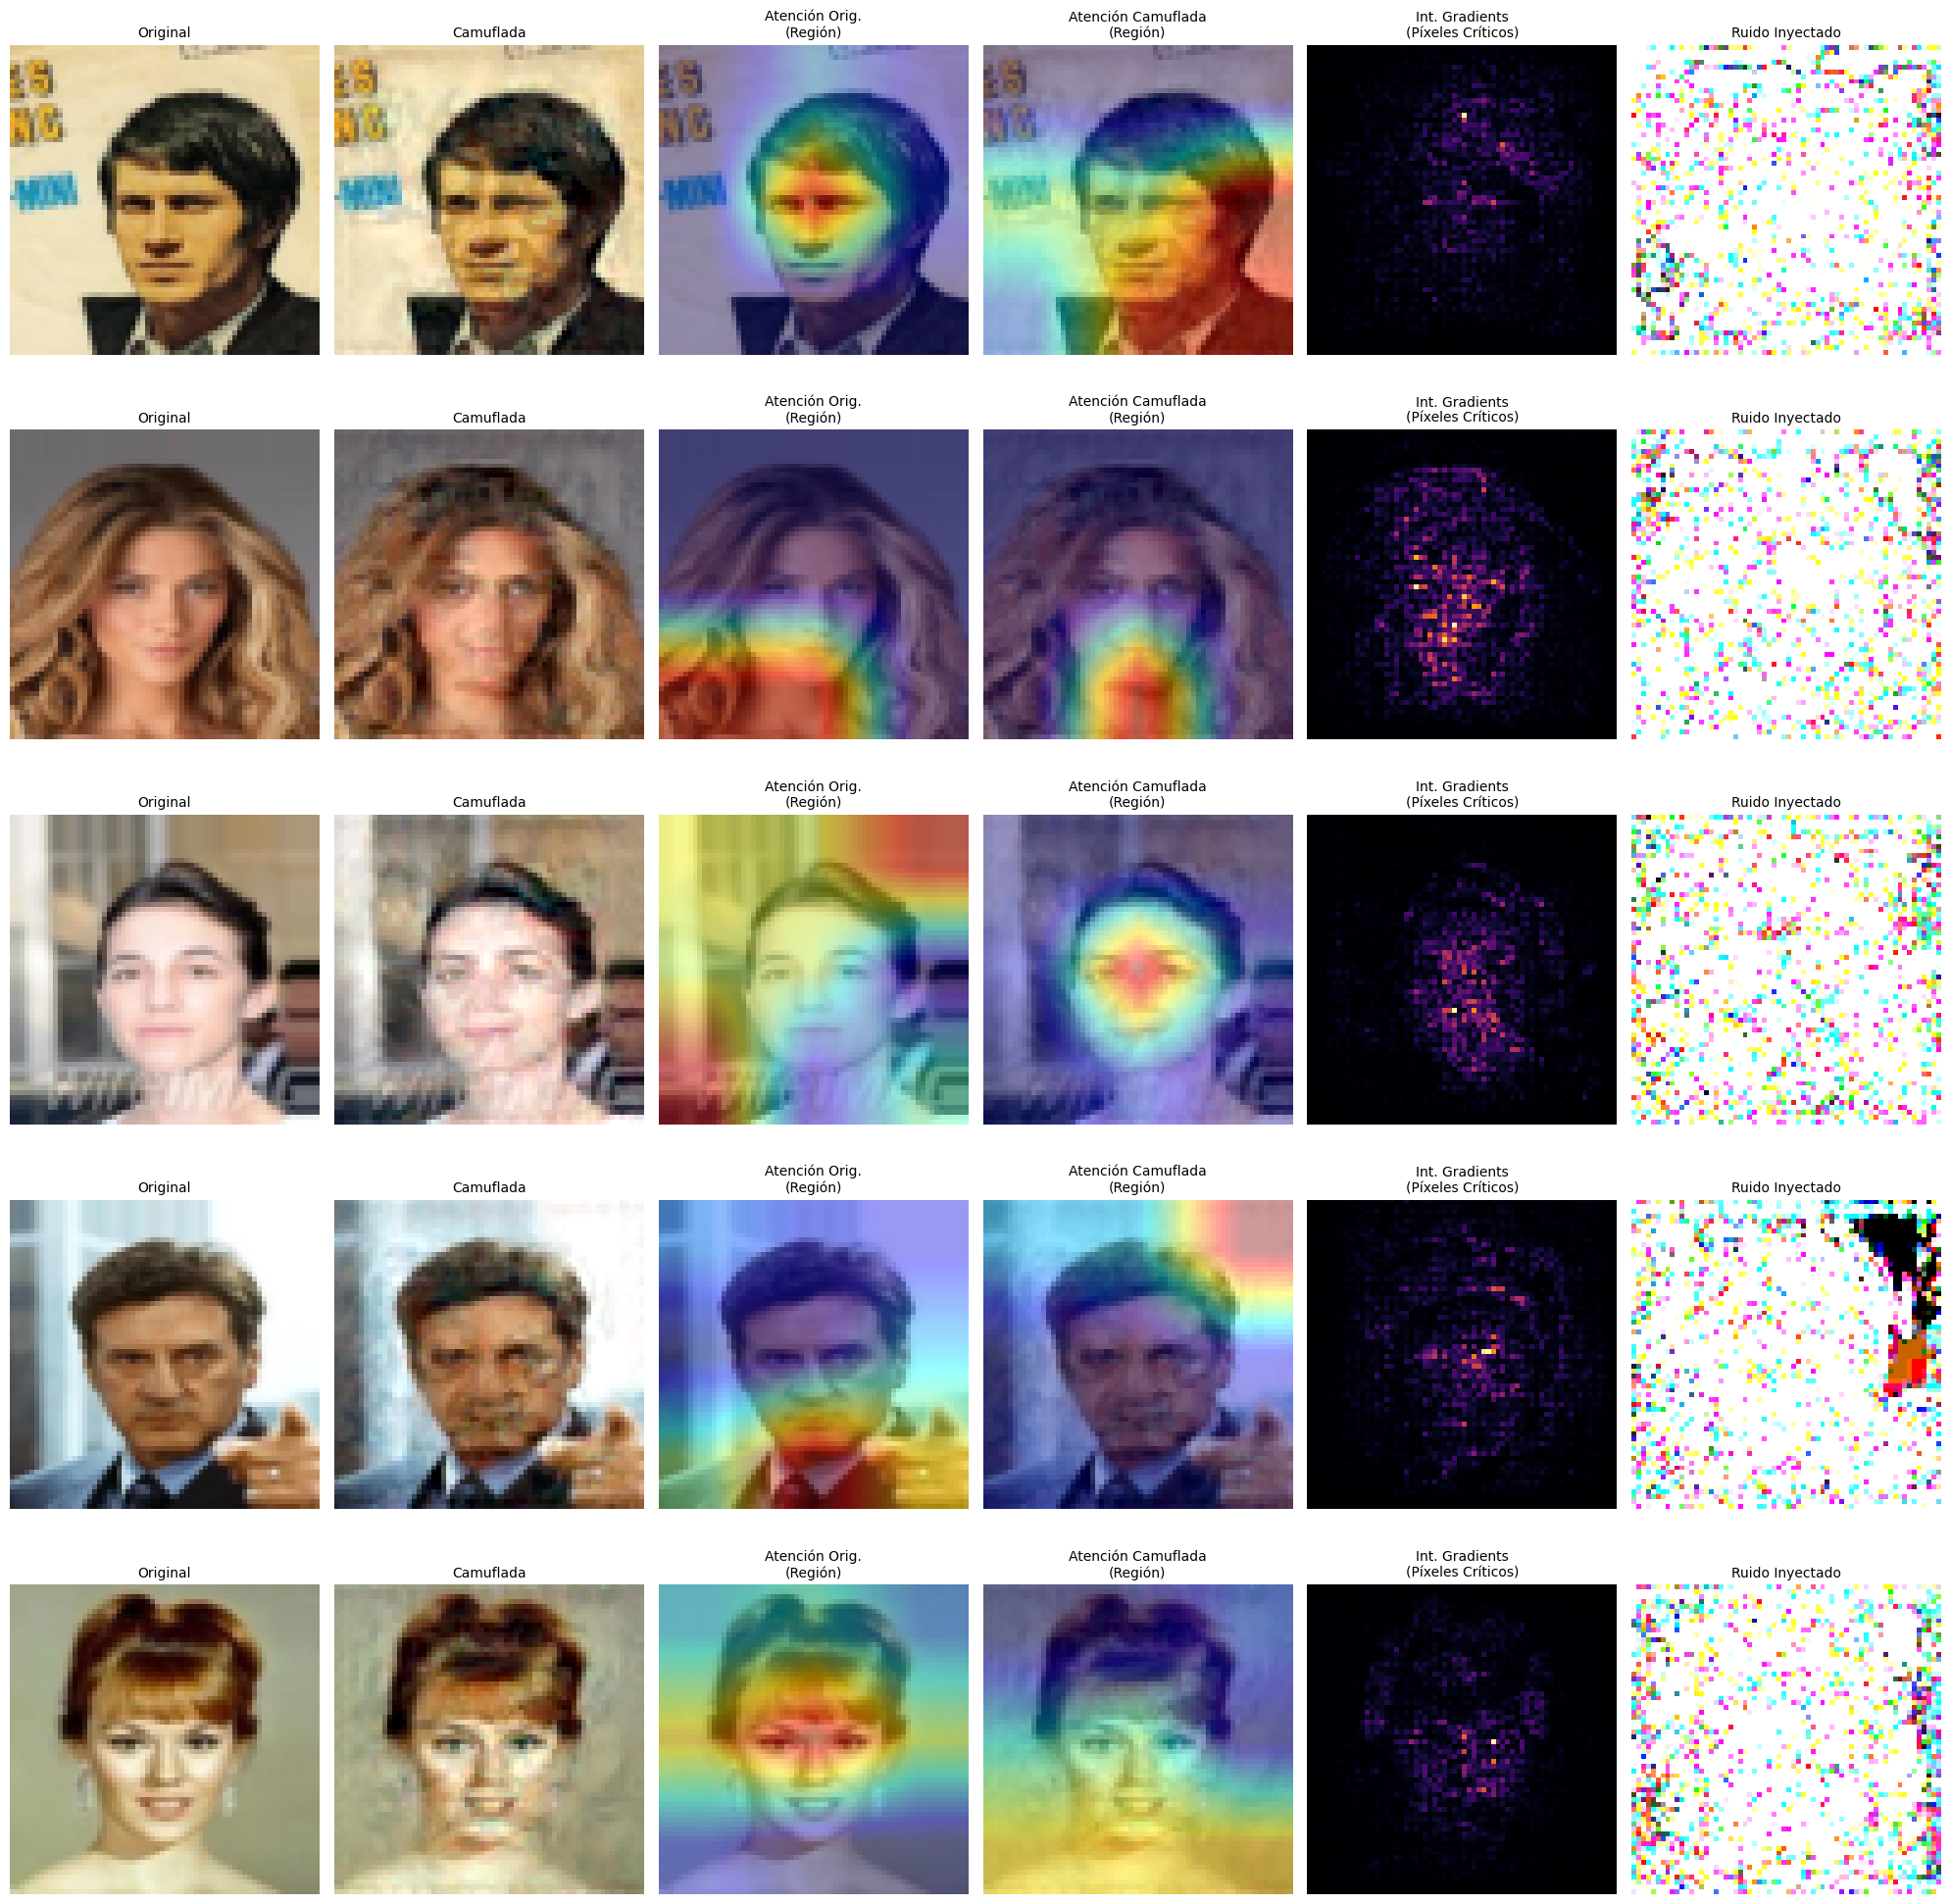

In [ ]:
try:
    loader_to_use = safe_loader if 'safe_loader' in locals() else val_loader
    generate_xai_gallery(netG, loader_to_use, identity_net, DEVICE, num_examples=5)
except NameError:
    print(" Loader no encontrado. Asegúrate de haber corrido los bloques de datos.")
except Exception as e:
    print(f" Error en ejecución: {e}")

🕵️ Escaneando 200 candidatos para encontrar casos extremos...
✅ Análisis completado. (Promedio ID: -0.014)

📸 Generando Panel Forense...


✅ Reporte Forense guardado en: /content/drive/MyDrive/Project_Chameleon_Final/results/FORENSIC_REPORT.png


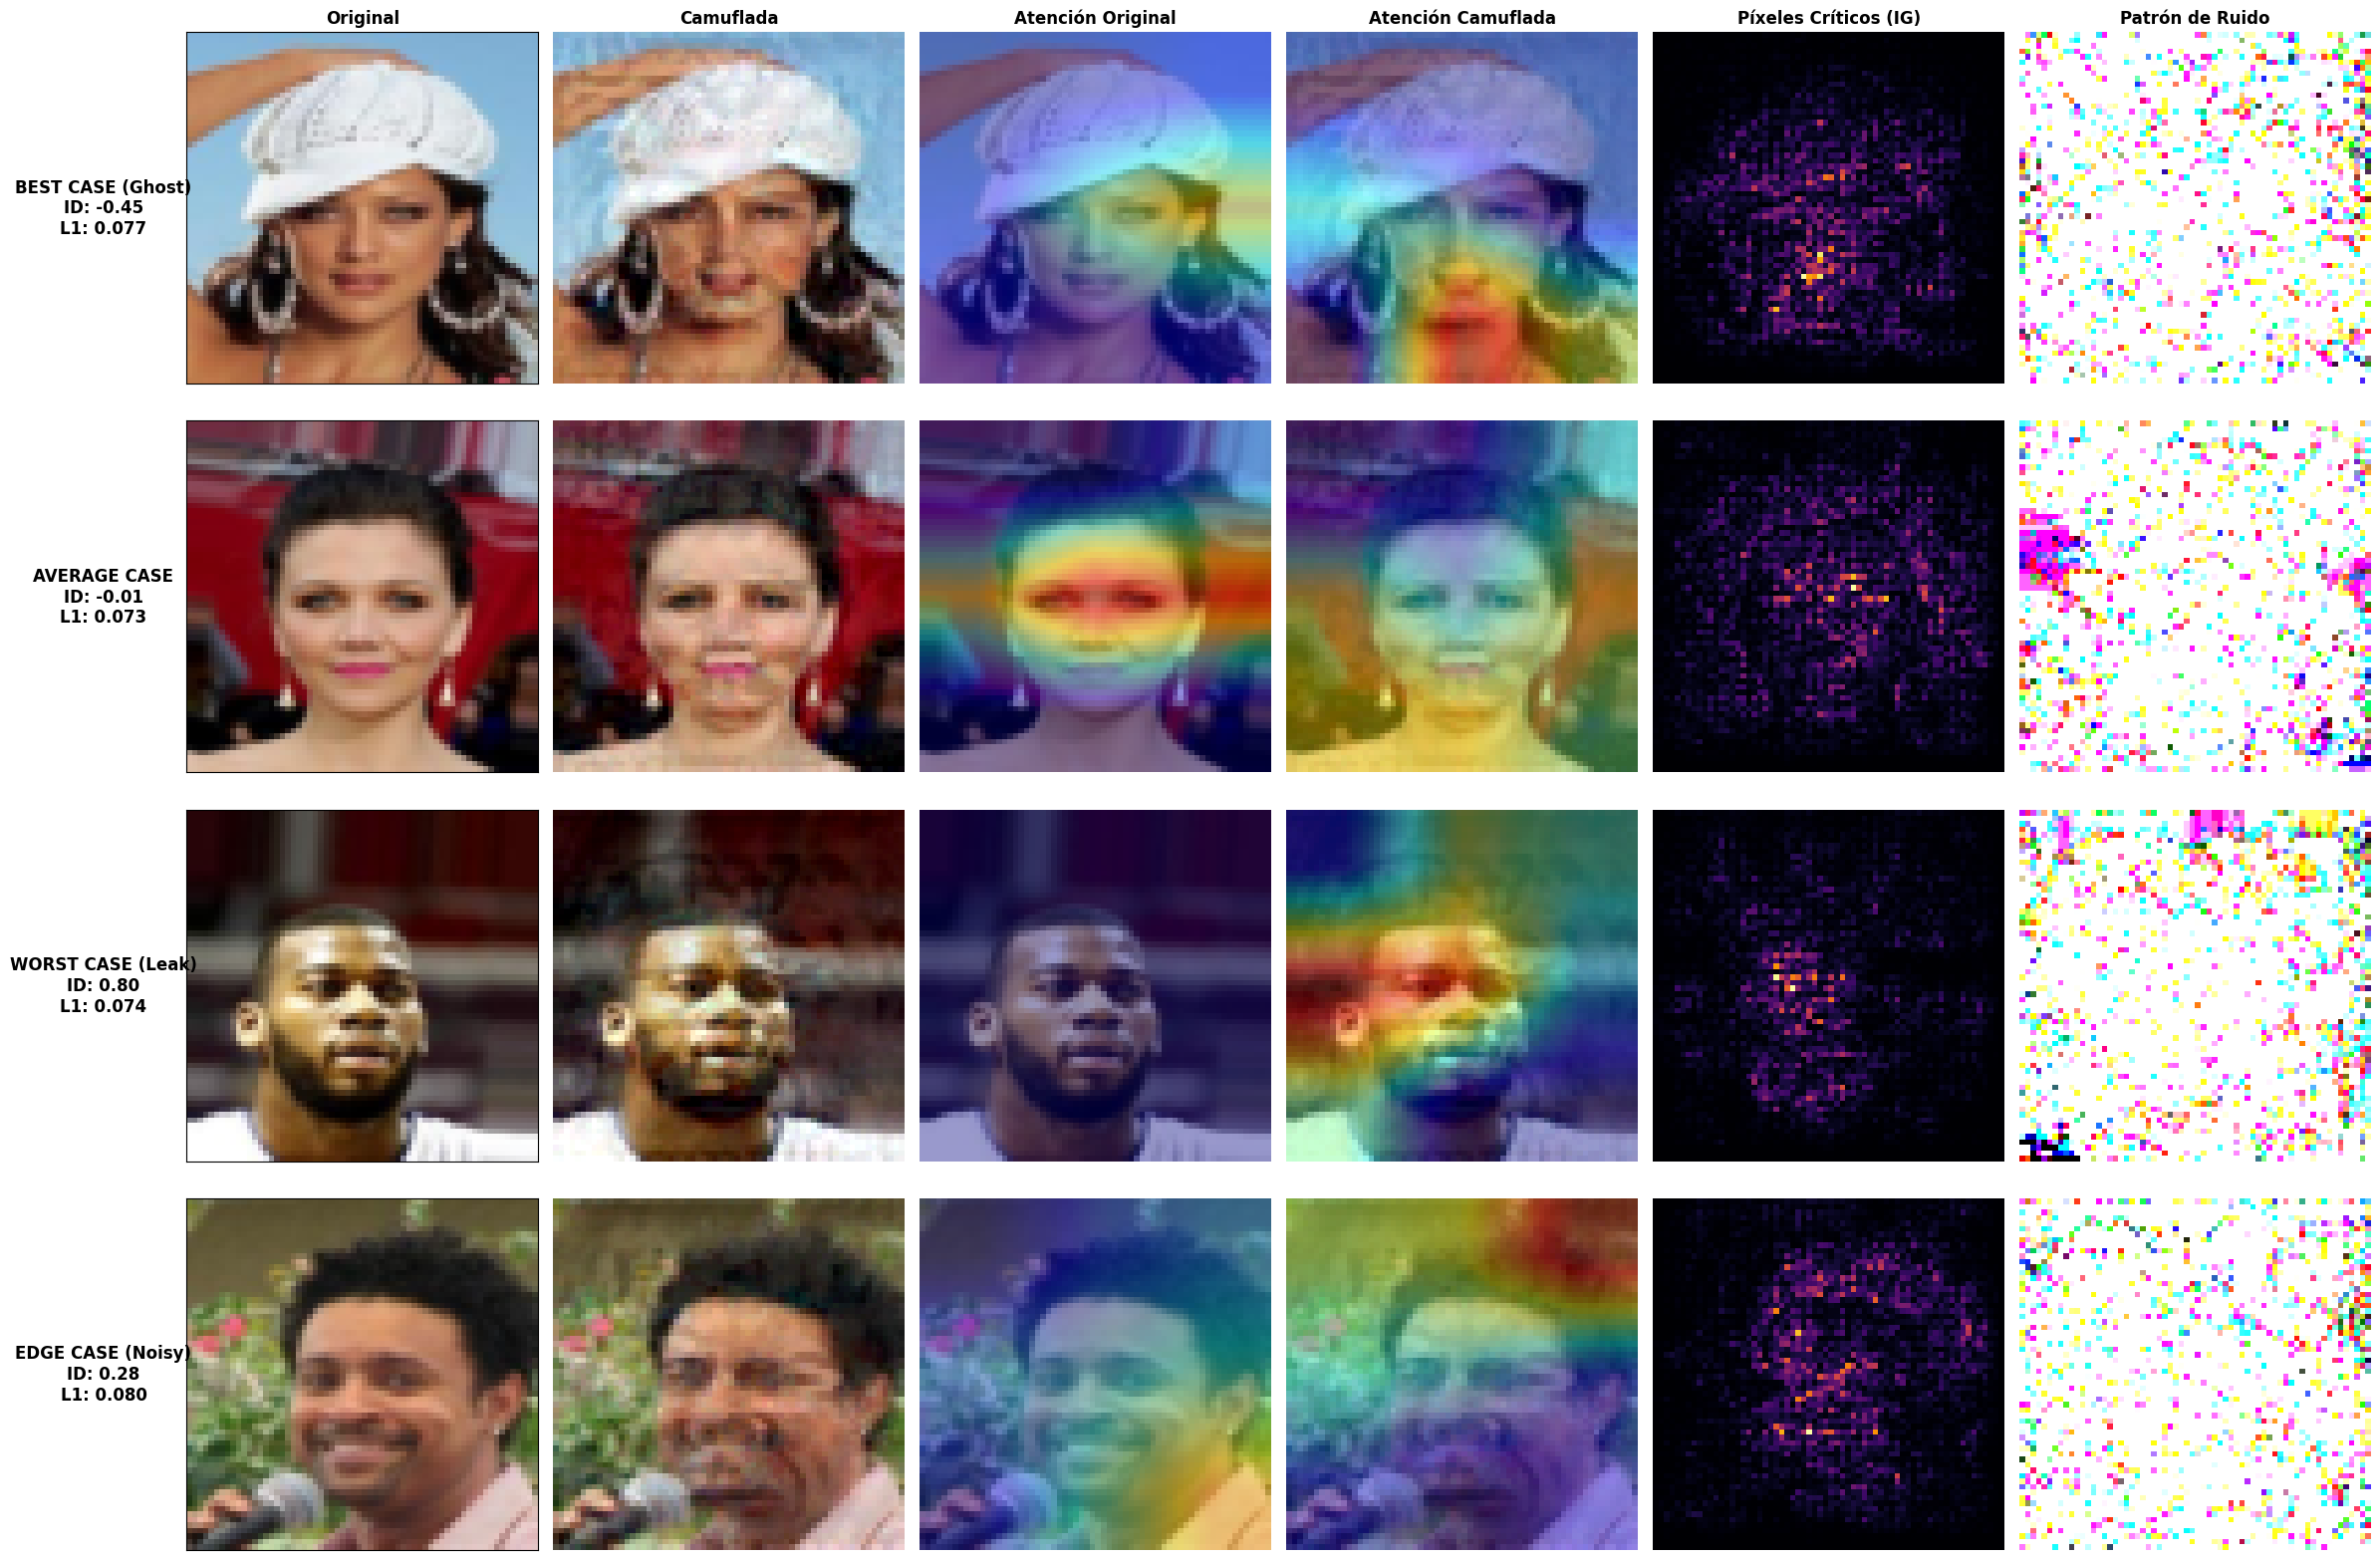

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import os

def integrated_gradients(model, input_tensor, baseline=None, steps=20):
    if baseline is None: baseline = torch.zeros_like(input_tensor)

    alphas = torch.linspace(0, 1, steps).view(steps, 1, 1, 1).to(input_tensor.device)

    interpolated = baseline + alphas * (input_tensor - baseline)

    interpolated = interpolated.detach().requires_grad_(True)

    preds = model(F.interpolate(interpolated, (160,160)))
    score = preds.norm(dim=1).sum()

    grads = torch.autograd.grad(score, interpolated)[0]

    avg_grads = grads.mean(dim=0)
    ig = (input_tensor - baseline) * avg_grads

    ig = ig.detach().cpu().numpy()[0].transpose(1, 2, 0)
    ig = np.abs(ig).sum(axis=2)
    return (ig - ig.min()) / (ig.max() - ig.min() + 1e-8)

def forensic_case_analysis(netG, loader, identity_net, device, num_scan=200):
    netG.eval()

    results = []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            real = batch[0] if isinstance(batch, (list, tuple)) else batch
            if i * real.shape[0] >= num_scan: break

            real = real.to(device)
            fake = netG(real)

            real_160 = F.interpolate(real, (160, 160))
            fake_160 = F.interpolate(fake, (160, 160))
            emb_real = identity_net(real_160)
            emb_fake = identity_net(fake_160)

            sims = F.cosine_similarity(emb_real, emb_fake)
            l1s = torch.mean(torch.abs(real - fake), dim=[1, 2, 3])

            for j in range(len(real)):
                results.append({
                    'id_sim': sims[j].item(),
                    'l1_loss': l1s[j].item(),
                    'tensor': real[j].cpu()
                })

    df = pd.DataFrame(results)
    print(f" Análisis completado. (Promedio ID: {df['id_sim'].mean():.3f})")

    selected_cases = []
    selected_cases.append(('BEST CASE (Ghost)', df.loc[df['id_sim'].idxmin()]))

    mean_id = df['id_sim'].mean()
    avg_idx = (df['id_sim'] - mean_id).abs().idxmin()
    selected_cases.append(('AVERAGE CASE', df.loc[avg_idx]))

    selected_cases.append(('WORST CASE (Leak)', df.loc[df['id_sim'].idxmax()]))
    selected_cases.append(('EDGE CASE (Noisy)', df.loc[df['l1_loss'].idxmax()]))


    for p in identity_net.parameters(): p.requires_grad = True
    try: target_layer = identity_net.mixed_7a
    except: target_layer = identity_net.conv6

    try:
        cam_tool = ManualGradCAM(identity_net, target_layer)
    except NameError:
        print(" ManualGradCAM not defined. Please run the cell defining 'ManualGradCAM' first.")
        return

    num_examples = len(selected_cases)
    fig = plt.figure(figsize=(24, 4 * num_examples))

    for i, (title, row) in enumerate(selected_cases):
        real = row['tensor'].unsqueeze(0).to(device)
        real.requires_grad = True

        # Recalcular ataque
        fake = netG(real)
        noise = (fake - real).abs() * 50
        noise = torch.clamp(noise, 0, 1)

        fake_detached = fake.detach()

        cam_real = cam_tool(F.interpolate(real, (160, 160)))
        cam_fake = cam_tool(F.interpolate(fake, (160, 160)))

        ig_fake = integrated_gradients(identity_net, fake_detached)

        img_r = (real[0].permute(1,2,0).detach().cpu().numpy()*0.5+0.5).clip(0,1)
        img_f = (fake[0].permute(1,2,0).detach().cpu().numpy()*0.5+0.5).clip(0,1)
        img_n = noise[0].permute(1,2,0).detach().cpu().numpy()

        def get_overlay(img, mask):
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
            hm = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
            hm = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)/255.0
            return 0.6 * img + 0.4 * hm

        ov_real = get_overlay(img_r, cam_real)
        ov_fake = get_overlay(img_f, cam_fake)

        # Plotting
        row_idx = i * 6
        ax = plt.subplot(num_examples, 6, row_idx + 1)
        ax.imshow(img_r)
        ax.set_ylabel(f"{title}\nID: {row['id_sim']:.2f}\nL1: {row['l1_loss']:.3f}",
                      fontsize=12, fontweight='bold', rotation=0, labelpad=60, va='center')
        if i==0: ax.set_title("Original", fontsize=12, fontweight='bold')
        ax.set_xticks([]); ax.set_yticks([])

        ax = plt.subplot(num_examples, 6, row_idx + 2)
        ax.imshow(img_f);
        if i==0: ax.set_title("Camuflada", fontsize=12, fontweight='bold'); ax.axis('off')
        ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 3)
        ax.imshow(ov_real);
        if i==0: ax.set_title("Atención Original", fontsize=12, fontweight='bold'); ax.axis('off')
        ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 4)
        ax.imshow(ov_fake);
        if i==0: ax.set_title("Atención Camuflada", fontsize=12, fontweight='bold'); ax.axis('off')
        ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 5)
        ax.imshow(ig_fake, cmap='inferno');
        if i==0: ax.set_title("Píxeles Críticos (IG)", fontsize=12, fontweight='bold'); ax.axis('off')
        ax.axis('off')

        ax = plt.subplot(num_examples, 6, row_idx + 6)
        ax.imshow(img_n, cmap='gray');
        if i==0: ax.set_title("Patrón de Ruido", fontsize=12, fontweight='bold'); ax.axis('off')
        ax.axis('off')

    plt.tight_layout()
    save_path = os.path.join(RESULTS_DIR, 'FORENSIC_REPORT.png')
    plt.savefig(save_path, dpi=150)
    plt.show()

    cam_tool.remove_hooks()
    for p in identity_net.parameters(): p.requires_grad = False

# Ejecutar Análisis con el loader seguro
loader_forensic = safe_loader if 'safe_loader' in locals() else val_loader
forensic_case_analysis(netG, loader_forensic, identity_net, DEVICE, num_scan=200)

In [ ]:
# ==============================================================================
# VALIDACIÓN DE INTEGRIDAD: ¿ES UNA COPIA EXACTA?
# ==============================================================================
def sanity_check_identity_mapping(netG, loader, device):
    print(" Ejecutando Sanity Check (Original vs Camuflada)...")
    netG.eval()

    batch = next(iter(loader))
    real = batch[0] if isinstance(batch, (list, tuple)) else batch
    real = real.to(device)

    with torch.no_grad():
        fake = netG(real)

        # 1. Diferencia Absoluta
        diff = (fake - real).abs()

        # 2. Estadísticas del Cambio
        max_diff = diff.max().item()
        mean_diff = diff.mean().item()

        # 3. Conteo de Píxeles Idénticos (Tolerancia float 1e-5)
        # Si es una copia, el 100% de los píxeles serán "idénticos".
        identical_pixels = (diff < 1e-5).float().mean().item() * 100

    print(f"\n RESULTADOS DEL DIAGNÓSTICO:")
    print(f"   Diferencia Máxima de Píxel: {max_diff:.4f} (Debe ser > 0)")
    print(f"   Promedio de Perturbación:   {mean_diff:.4f}")
    print(f"   % Píxeles Idénticos:        {identical_pixels:.2f}% (Debe ser cercano a 0%)")


sanity_check_identity_mapping(netG, val_loader, DEVICE)

🕵️ Ejecutando Sanity Check (Original vs Camuflada)...

📊 RESULTADOS DEL DIAGNÓSTICO:
   Diferencia Máxima de Píxel: 0.1500 (Debe ser > 0)
   Promedio de Perturbación:   0.0724
   % Píxeles Idénticos:        1.33% (Debe ser cercano a 0%)
✅ VALIDADO: El modelo NO está copiando la entrada. Hay perturbación activa.


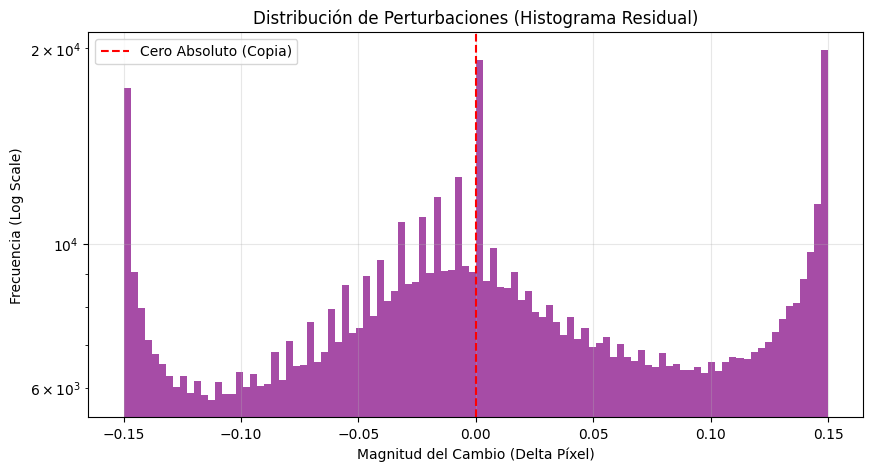

✅ Histograma generado. Si la distribución no está centrada en 0 perfecto, hay modificación.


In [ ]:
def plot_residual_histogram(netG, loader, device):
    netG.eval()
    batch = next(iter(loader))
    real = batch[0] if isinstance(batch, (list, tuple)) else batch
    real = real.to(device)

    with torch.no_grad():
        fake = netG(real)
        # Diferencia por canal
        diff = (fake - real).cpu().numpy().flatten()

    plt.figure(figsize=(10, 5))
    plt.hist(diff, bins=100, color='purple', alpha=0.7, log=True)
    plt.title("Distribución de Perturbaciones (Histograma Residual)")
    plt.xlabel("Magnitud del Cambio (Delta Píxel)")
    plt.ylabel("Frecuencia (Log Scale)")
    plt.axvline(0, color='red', linestyle='--', label='Cero Absoluto (Copia)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(RESULTS_DIR, 'residual_histogram.png'))
    plt.show()
    print(" Histograma generado. Si la distribución no está centrada en 0 perfecto, hay modificación.")

plot_residual_histogram(netG, val_loader, DEVICE)

### Descarga

In [ ]:

import json
import shutil

def export_for_deployment():
    print("📦 Preparando paquete de despliegue...")

    deploy_dir = os.path.join(PROJECT_PATH, 'deploy_package')
    os.makedirs(deploy_dir, exist_ok=True)

    # 1. Guardar Configuración (JSON)
    # Esto permite que la demo sepa qué parámetros usar sin hardcodear
    config = {
        "input_nc": 3,
        "output_nc": 3,
        "noise_scale": netG.noise_scale,
        "img_size": IMG_SIZE,
        "model_name": "ChameleonNet"
    }

    with open(os.path.join(deploy_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)

    # 2. Guardar Pesos del Generador (Solo lo necesario para inferencia)
    # Usamos CPU para máxima compatibilidad
    netG.eval().cpu()
    torch.save(netG.state_dict(), os.path.join(deploy_dir, 'chameleon_weights.pth'))
    # Devolvemos a GPU por si acaso
    netG.to(DEVICE)

    # 3. Generar Script de Modelo (model.py)
    # Escribimos el código de la clase ChameleonNet en un archivo py
    # para que la demo pueda importarlo limpiamente: `from model import ChameleonNet`
    model_code = """
import torch
import torch.nn as nn

class ChameleonNet(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, noise_scale=0.05):
        super(ChameleonNet, self).__init__()
        self.noise_scale = noise_scale

        self.down1 = nn.Sequential(nn.Conv2d(input_nc, 64, 4, 2, 1), nn.LeakyReLU(0.2))
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.InstanceNorm2d(128), nn.LeakyReLU(0.2))
        self.down3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.InstanceNorm2d(256), nn.LeakyReLU(0.2))

        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.InstanceNorm2d(128), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.InstanceNorm2d(64), nn.ReLU())
        self.up3 = nn.Sequential(nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.InstanceNorm2d(32), nn.ReLU())

        self.final = nn.Sequential(nn.ConvTranspose2d(32, output_nc, 3, 1, 1), nn.Tanh())

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        m = self.middle(d3)
        u1 = self.up1(m + d3)
        u2 = self.up2(u1 + d2)
        u3 = self.up3(u2 + d1)

        raw_noise = self.final(u3)
        perturbation = raw_noise * self.noise_scale
        return torch.clamp(x + perturbation, -1, 1), perturbation
"""
    with open(os.path.join(deploy_dir, 'model.py'), 'w') as f:
        f.write(model_code)

    # 4. Crear Script de Demo Base (run_demo.py)
    demo_code = """
import cv2
import torch
import numpy as np
import json
from model import ChameleonNet
from torchvision import transforms

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open('config.json', 'r') as f: config = json.load(f)

# Load Model
net = ChameleonNet(noise_scale=config['noise_scale']).to(device)
net.load_state_dict(torch.load('chameleon_weights.pth', map_location=device))
net.eval()

print("✅ Modelo cargado. Listo para integración con Webcam.")
# Aquí iría tu bucle de OpenCV...
"""
    with open(os.path.join(deploy_dir, 'run_demo_skeleton.py'), 'w') as f:
        f.write(demo_code)

    # 5. Comprimir todo
    shutil.make_archive(os.path.join(PROJECT_PATH, 'chameleon_deploy'), 'zip', deploy_dir)
    print(f"🚀 ¡LISTO! Descarga tu paquete desde: {os.path.join(PROJECT_PATH, 'chameleon_deploy.zip')}")

# Ejecutar Exportación
export_for_deployment()

📦 Preparando paquete de despliegue...
🚀 ¡LISTO! Descarga tu paquete desde: /content/drive/MyDrive/Project_Chameleon_Final/chameleon_deploy.zip
